In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# -------------------------------
# 1. Load the Data
# -------------------------------
# Assume the first column in both files is a sample identifier. 
# Adjust index_col accordingly if your files are structured differently.

# Load gene expression data
expr_data = pd.read_csv("KSV_Gex_Reduced.csv", index_col=0)

# Load cluster labels data
clusters = pd.read_csv("Paper_Sample_Clusters.csv", index_col=0)

# Merge the data on the sample identifier
data = expr_data.join(clusters, how='inner')

# -------------------------------
# 2. Prepare Features and Labels
# -------------------------------
# Assuming that the clusters file has a column named 'cluster' for the label
X = data.drop("cluster", axis=1)
y = data["cluster"]

# If the cluster labels are not numeric, encode them
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Convert to categorical (one-hot encoding) for classification
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# -------------------------------
# 3. Split and Scale the Data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

# Scale features (gene expression values) for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 4. Build the Neural Network
# -------------------------------
model = Sequential()
# Input layer with neurons (you can tune the number of neurons)
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))  # dropout helps to prevent overfitting

# Additional hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer: use softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------
# 5. Train the Neural Network
# -------------------------------
history = model.fit(
    X_train_scaled, y_train, 
    epochs=50,           # you may adjust the number of epochs
    batch_size=32,       # adjust batch size based on your dataset
    validation_split=0.1 # reserve 10% of training data for validation
)

# -------------------------------
# 6. Evaluate the Model
# -------------------------------
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


c:\Users\Max Sleek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3750 - loss: 1.7710 - val_accuracy: 1.0000 - val_loss: 0.5782
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5833 - loss: 0.9157 - val_accuracy: 1.0000 - val_loss: 0.5015
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.6250 - loss: 0.8960 - val_accuracy: 1.0000 - val_loss: 0.4396
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step - accuracy: 0.5833 - loss: 0.9418 - val_accuracy: 1.0000 - val_loss: 0.3871
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step - accuracy: 0.6250 - loss: 0.7461 - val_accuracy: 1.0000 - val_loss: 0.3430
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step - accuracy: 0.7083 - loss: 0.4595 - val_accuracy: 1.0000 - val_loss: 0.3079
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.5833 - loss: 0.6931 - val_accuracy: 1.0000 - val_loss: 0.2786
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step - accuracy: 0.7917 - loss: 0.3980 - val_accuracy: 1.0000 - val_loss: 0.253

Plots

In [2]:
# Loss, Epochs
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

In [8]:
#PCA Scatterplot
from sklearn.decomposition import PCA
def plot_pca(X, y, encoder):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y)
    for label in unique_labels:
        idx = y == label
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=encoder.inverse_transform([label])[0])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection of Gene Expression Data")
    plt.legend()
    plt.show()

In [34]:
#SHAP Feature Importance
import shap

def plot_shap_values_unified(model, X_sample, feature_names=None):
    # Convert X_sample to a NumPy array if needed.
    if isinstance(X_sample, pd.DataFrame):
        X_array = X_sample.values
    else:
        X_array = X_sample

    # Use a subset of samples as the background (e.g. up to 100 samples).
    if X_array.shape[0] > 100:
        idx = np.random.choice(X_array.shape[0], 100, replace=False)
        background = X_array[idx]
    else:
        background = X_array

    # Create the unified explainer.
    explainer = shap.Explainer(model, background)
    # Get the SHAP values. This returns an Explanation object.
    shap_values = explainer(X_array)

    # Convert the input back to a DataFrame if feature names are provided.
    if feature_names is not None:
        X_for_plot = pd.DataFrame(X_array, columns=feature_names)
    else:
        X_for_plot = X_array

    #print(shap_values)

    # Use the .values attribute from the Explanation object for plotting.
    shap.summary_plot(shap_values.values, X_for_plot, feature_names=feature_names)

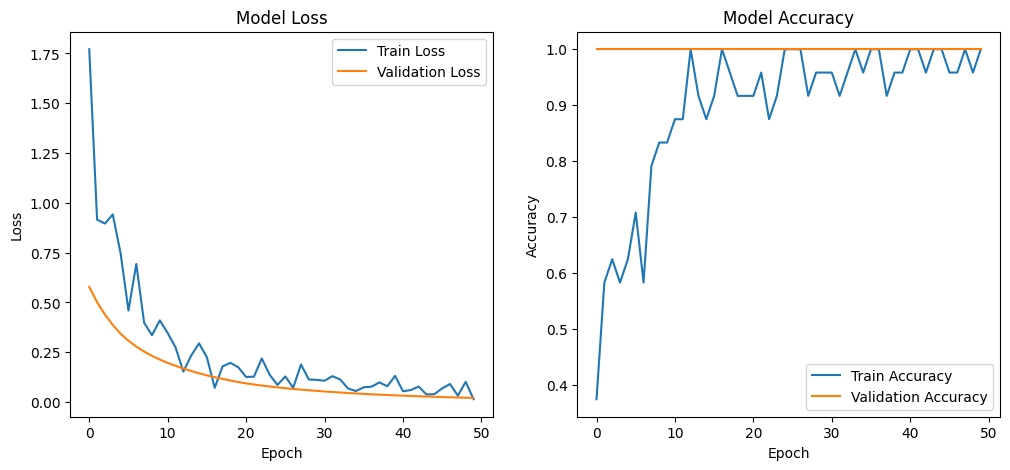

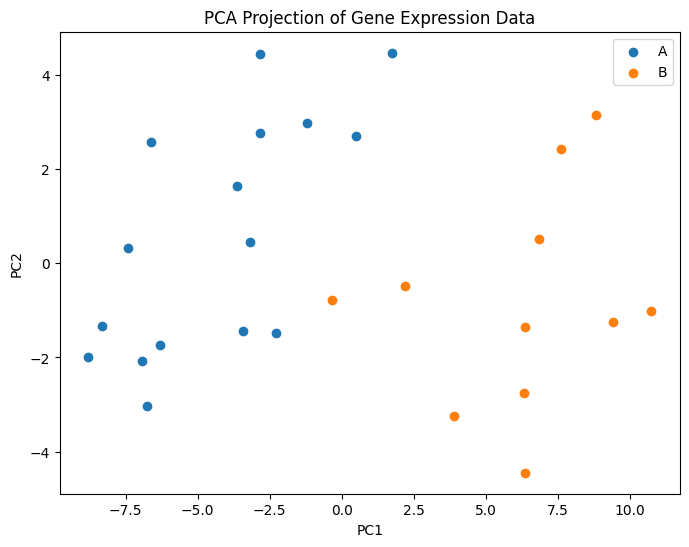

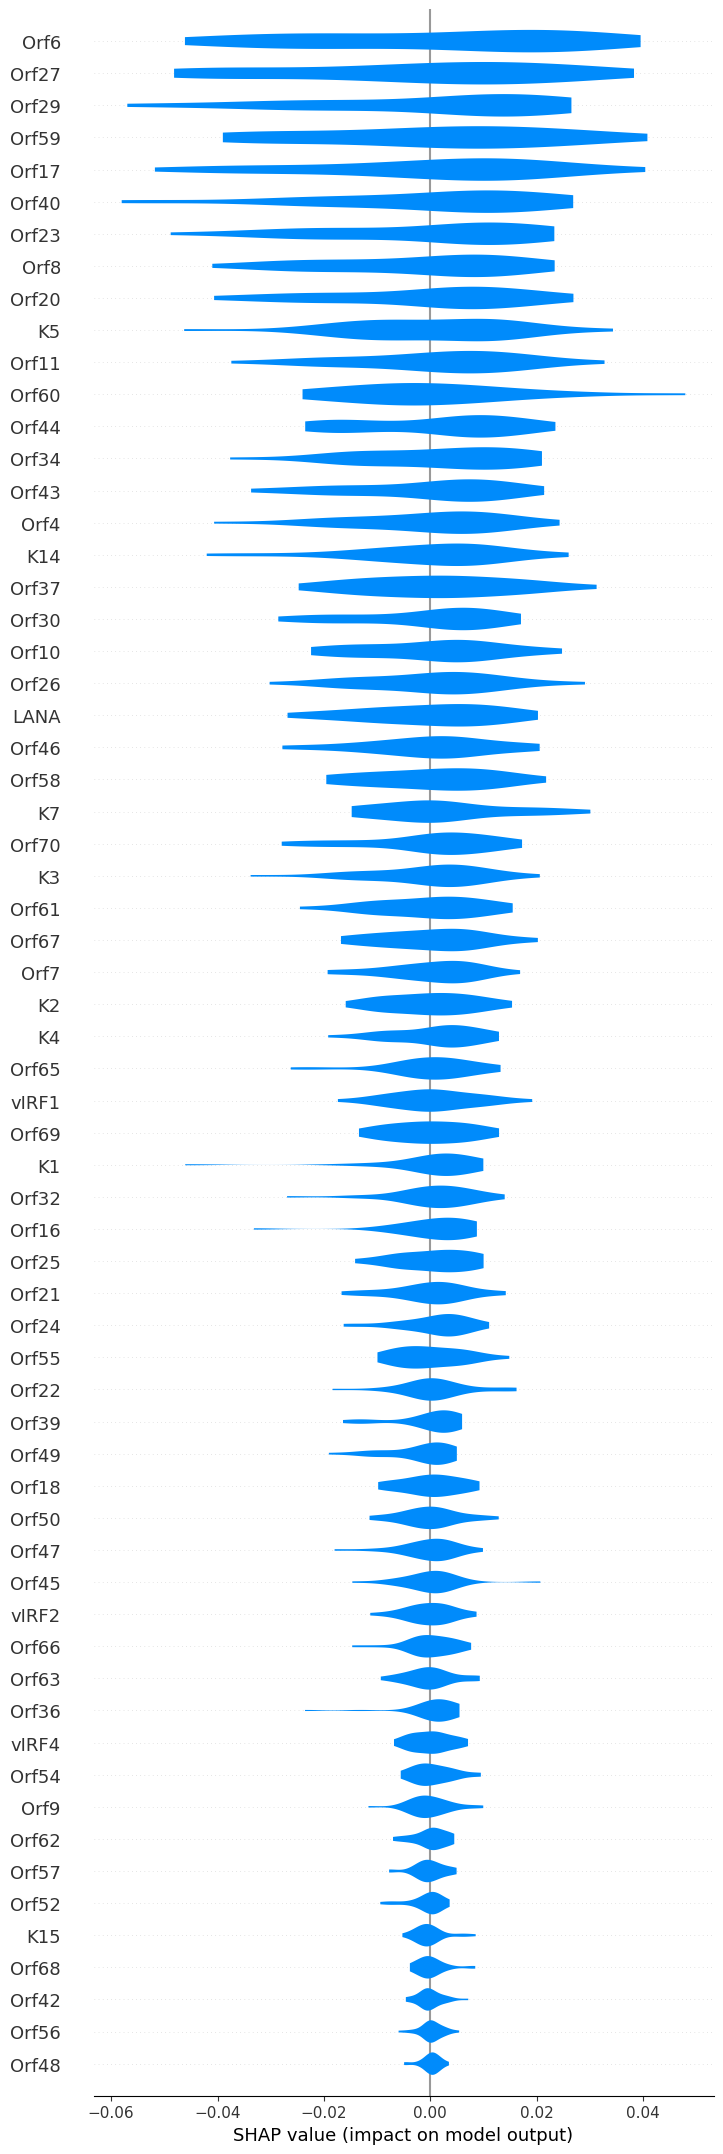

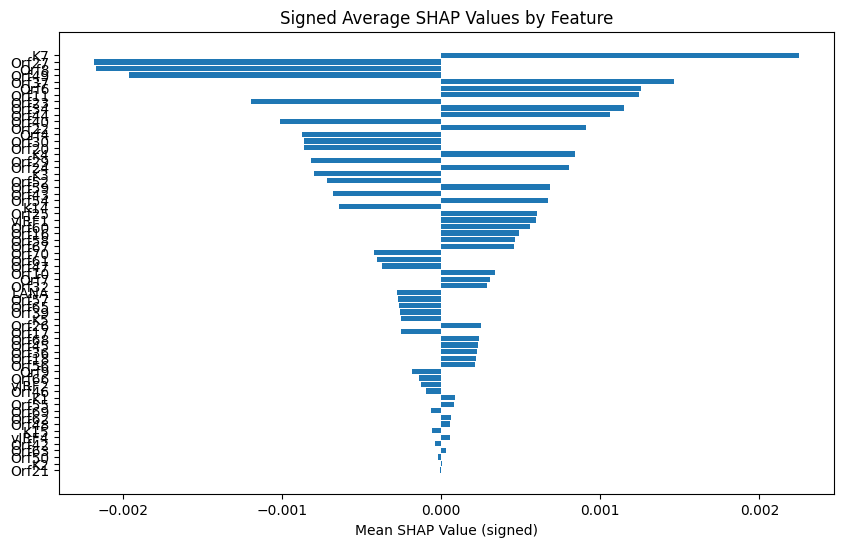

In [46]:
# Plot training history (after model.fit)
plot_training_history(history)

# Visualize PCA projection (using the scaled training data or full dataset)
plot_pca(X_train_scaled, np.argmax(y_train, axis=1), encoder)

# Plot SHAP feature importance (using a sample of the training data)
# If you have gene names, pass them as feature_names; otherwise, they will be numbered.
#plot_shap_values_unified(model, X_train_scaled, feature_names=X.columns.tolist())

#------------------------
#Shap values violin plot

# Select class 0's SHAP values:
sv = shap_values.values
if len(sv.shape) == 3:
    sv = sv[:, :, 0]  # Now sv has shape (n_samples, n_features)
shap.plots.violin(sv, feature_names=X.columns.tolist(), max_display=64)

#-------------------------

#SHAP values bar plot

# Compute the mean of the raw (signed) SHAP values for each feature
mean_shap = np.mean(sv, axis=0)  # shape (64,)

# Create a DataFrame for easier plotting and sorting
df_shap = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'Mean_SHAP': mean_shap
})

# Sort features by the absolute mean SHAP values in descending order
df_shap = df_shap.sort_values('Mean_SHAP', key=lambda x: np.abs(x), ascending=False)

# Plot a horizontal bar chart of the signed average SHAP values
plt.figure(figsize=(10, 6))
plt.barh(df_shap['Feature'], df_shap['Mean_SHAP'])
plt.xlabel("Mean SHAP Value (signed)")
plt.title("Signed Average SHAP Values by Feature")
plt.gca().invert_yaxis()  # invert y-axis to show the most important feature at the top
plt.show()

In [50]:
# Suppose 'clusters_df' is your DataFrame loaded from Paper_Sample_Clusters.csv
# and it has an index that matches your gene expression data.
clusters_df = pd.read_csv("Paper_Sample_Clusters.csv", index_col=0)

# Assume X_train_scaled is a DataFrame. Reindex clusters to match the samples in X_train_scaled.
aligned_clusters = clusters_df.reindex(X_train_scaled.index)

# Check the shape to ensure they match
print("X_train_scaled shape:", X_train_scaled.shape)  # e.g., (27, 64)
print("Aligned cluster labels shape:", aligned_clusters.shape)  # Should be (27, ?)

# Now extract the cluster labels (assuming the column is named 'cluster')
cluster_labels_aligned = aligned_clusters['cluster'].values

# At this point, your cluster_labels_aligned should have 27 entries.
# Now split your SHAP Explanation object (assume shap_exp is already built)
mask_cluster0 = (cluster_labels_aligned == 0)
mask_cluster1 = (cluster_labels_aligned == 1)

shap_cluster0 = shap_exp[mask_cluster0]
shap_cluster1 = shap_exp[mask_cluster1]

# Build dictionary of cohorts and plot
cohorts_dict = {
    "Cluster 0": shap_cluster0,
    "Cluster 1": shap_cluster1
}

shap.plots.bar(cohorts_dict, max_display=64)

AttributeError: 'numpy.ndarray' object has no attribute 'index'